# Implementing Forward Gradient

Laboratory to implement `gradient_fwd` function, proposed [here](https://arxiv.org/abs/2202.08587).

In [1]:
import torch
import torch.func as fc
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

import numpy as np
import math

from tqdm import tqdm
import matplotlib.pyplot as plt

from import_shelf import shelf
from shelf.models.transformer import VisionTransformer
from shelf.dataloaders.cifar import get_CIFAR10_dataset
from shelf.trainers.classic import train, validate
from shelf.trainers.zeroth_order import gradient_fwd, group_by_gradient_exp

In [2]:
## HYPERPARAMS ##

BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


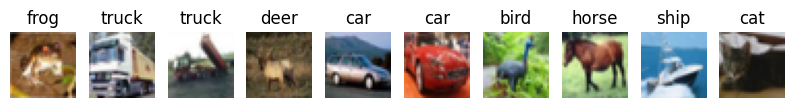

In [3]:
### DATA LOADING ###

train_loader, val_loader = get_CIFAR10_dataset(batch_size=BATCH_SIZE)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_loader.dataset.data[i])
    plt.title(classes[train_loader.dataset.targets[i]])
    plt.axis('off')

In [4]:
## MODEL ##

model = VisionTransformer(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=512,
    depth=4,
    heads=6,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
).to(DEVICE)

# model = VisionTransformer(
#     image_size=32,
#     patch_size=4,
#     num_classes=10,
#     dim=16,
#     depth=1,
#     heads=1,
#     mlp_dim=16,
#     dropout=0.1,
#     emb_dropout=0.1
# ).to(DEVICE)

model.load_state_dict(torch.load('./saves/fwdgge_tinyvit_e00101.pth'))

num_params = sum(p.numel() for p in model.parameters())

print(model)
print(f"Model has {num_params} parameters")

VisionTransformer(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=1152, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=384, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
              (1): GELU(ap

In [5]:
## OTHERS ##

criterion = nn.CrossEntropyLoss()

def functional_xent(
    params,
    buffers,
    names,
    model,
    x,
    t,
):
    y = fc.functional_call(model, ({k: v for k, v in zip(names, params)}, buffers), (x,))
    return F.cross_entropy(y, t)

In [6]:
## REAL GRADIENT ##

TRIAL = 10

manual_jvp = []
ad_jvp = []

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    named_buffers = dict(model.named_buffers())
    named_params = dict(model.named_parameters())
    names = named_params.keys()
    params = named_params.values()

    perturb_noise = tuple(torch.randn_like(p) for p in params)
    f = partial(functional_xent, model=model, names=names, buffers=named_buffers, x=input, t=target)
    loss, jvp = fc.jvp(f, (tuple(params),), (perturb_noise,))

    estimated_grads = torch.cat([jvp * p.flatten() for p in perturb_noise])

    ## COMPARISON ##
    perturb_noise_flat = torch.cat([p.flatten() for p in perturb_noise])
    jvp_manual = torch.dot(grads, perturb_noise_flat)

    manual_jvp.append(jvp_manual)
    ad_jvp.append(jvp)

## MSE ERROR ##
mse_error = torch.mean(torch.stack([(a-b).pow(2) for a, b in zip(manual_jvp, ad_jvp)]))
print(f"MSE error: {mse_error:.4f}")

100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

MSE error: 15.3398


In [7]:
## ABLATION: QUERY ##

TRIAL = 10

norm_q1 = []
norm_q10 = []
norm_q100 = []
norm_q1000 = []

cossim_q1 = []
cossim_q10 = []
cossim_q100 = []
cossim_q1000 = []

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=1)

    norm_q1.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()])) / torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
    cossim_q1.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=10)

    norm_q10.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()])) / torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
    cossim_q10.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=100)

    norm_q100.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()])) / torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
    cossim_q100.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

# for _ in tqdm(range(TRIAL)):
#     input, target = next(iter(train_loader))
#     input, target = input.to(DEVICE), target.to(DEVICE)

#     output = model(input)
#     loss = criterion(output, target)
#     model.zero_grad()
#     loss.backward()

#     grads = torch.cat([p.grad.flatten() for p in model.parameters()])

#     ## ESTIMATED GRADIENT ##
#     estimated_grads = gradient_fwd(input, target, model, functional_xent, query=1000)

#     norm_q1000.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()])) / torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
#     cossim_q1000.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

## COSINE SIMILARITY ##
cossim_q1 = torch.stack(cossim_q1)
cossim_q10 = torch.stack(cossim_q10)
cossim_q100 = torch.stack(cossim_q100)
# cossim_q1000 = torch.stack(cossim_q1000)

print(f"Cosine similarity (query=1): {cossim_q1.mean():.4f}, Norm: {torch.stack(norm_q1).mean():.4f}")
print(f"Cosine similarity (query=10): {cossim_q10.mean():.4f}, Norm: {torch.stack(norm_q10).mean():.4f}")
print(f"Cosine similarity (query=100): {cossim_q100.mean():.4f}, Norm: {torch.stack(norm_q100).mean():.4f}")
# print(f"Cosine similarity (query=1000): {cossim_q1000.mean():.4f}, Norm: {torch.stack(norm_q1000).mean():.4f}")


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

Cosine similarity (query=1): 0.0002, Norm: 1454.7344
Cosine similarity (query=10): 0.0004, Norm: 590.3223
Cosine similarity (query=100): 0.0024, Norm: 208.7704


In [8]:
## ABLATION: TYPE ##

TRIAL = 5

norm_rge = []
norm_pge = []

cossim_rge = []
cossim_pge = []

len_params = len(list(model.parameters()))
num_query = 3

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=num_query*len_params, type='rge')

    norm_rge.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))/torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
    cossim_rge.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

for _ in tqdm(range(TRIAL)):
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    output = model(input)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    grads = torch.cat([p.grad.flatten() for p in model.parameters()])

    ## ESTIMATED GRADIENT ##
    
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=num_query, type='pge')

    norm_pge.append(torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))/torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])))
    cossim_pge.append(torch.dot(grads, torch.cat([p.flatten() for p in estimated_grads.values()]) / torch.norm(grads) / torch.norm(torch.cat([p.flatten() for p in estimated_grads.values()]))))

## COSINE SIMILARITY ##
cossim_rge = torch.stack(cossim_rge)
cossim_pge = torch.stack(cossim_pge)

print(f"Number of query: {num_query*len_params}")
print(f"Cosine similarity (RGE): {cossim_rge.mean():.4f}, Norm: {torch.stack(norm_rge).mean():.4f}")
print(f"Cosine similarity (PGE): {cossim_pge.mean():.4f}, Norm: {torch.stack(norm_pge).mean():.4f}")

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]

Number of query: 156
Cosine similarity (RGE): 0.0026, Norm: 168.7488
Cosine similarity (PGE): 0.0020, Norm: 7235.8877


## GGE with Foward Gradient

In [9]:
def get_real_gradient(input, label, model, criterion):
    output = model(input)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()

    gradient_dict = {}
    for name, param in model.named_parameters():
        gradient_dict[name] = param.grad.clone()

    return gradient_dict


In [10]:
## PRETRAIN MODEL ##

PRETRAIN_EPOCH = 1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(PRETRAIN_EPOCH):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_acc, val_loss = validate(val_loader, model, criterion, epoch)

    print(f"Epoch {epoch+1}/{PRETRAIN_EPOCH} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

Epoch 1/1 - Train loss: 2.1106, Train acc: 0.2315, Val loss: 1.7504, Val acc: 0.3391


Cosine similarity (RGE): 0.0122, Norm: 68.0383
Cosine similarity (PGE): 0.0125, Norm: 3633.8193
Cosine similarity (GGE): 0.5031, Norm: 0.8719


/tmp/ipykernel_2785209/2752127691.py:51: RuntimeWarning: divide by zero encountered in log
  gradient_stacked = np.stack([np.log(real_gradient_abs), np.log(parameter_abs), np.log(rge_gradient_abs), np.log(pge_gradient_abs), np.log(gge_gradient_abs)])


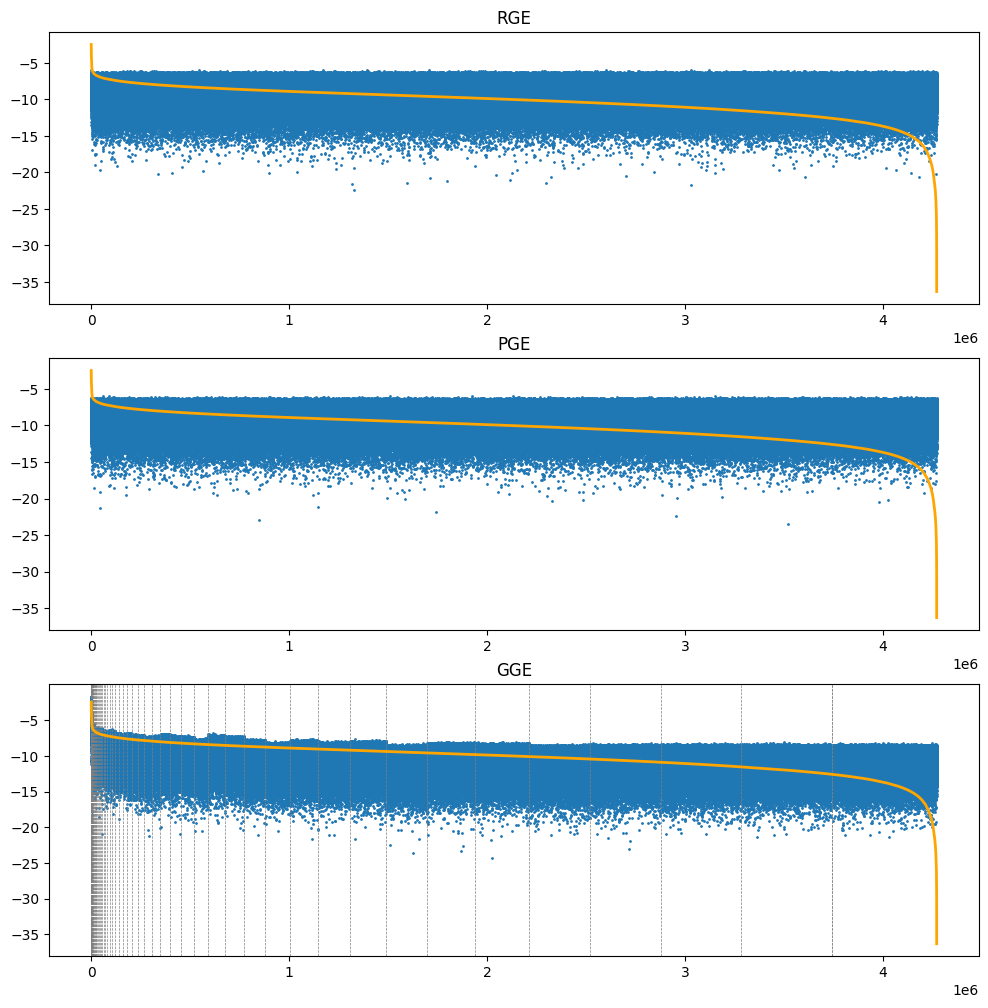

In [14]:
## SHOW GRADIENT ##
input, target = next(iter(train_loader))
input, target = input.to(DEVICE), target.to(DEVICE)

config = {}

num_query = 1000
num_groups = 100

parameter = dict(model.named_parameters())
parameter = torch.cat([p.flatten() for p in parameter.values()]).cpu().detach().numpy()
norm_parameter = np.linalg.norm(parameter)
parameter_abs = np.abs(parameter) / norm_parameter

real_gradient = get_real_gradient(input, target, model, criterion)
partition_dict, group_sizes = group_by_gradient_exp(real_gradient, num_groups, descending=True, level_noise=0.0, config=config)
real_num_groups = num_groups
real_gradient = torch.cat([p.flatten() for p in real_gradient.values()])
real_gradient = real_gradient.cpu().detach().numpy()
norm_real_gradient = np.linalg.norm(real_gradient)
real_gradient_abs = np.abs(real_gradient) / norm_real_gradient

rge_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query, type='rge')
rge_gradient = torch.cat([p.flatten() for p in rge_gradient.values()])
rge_gradient = rge_gradient.cpu().detach().numpy()
norm_rge_gradient = np.linalg.norm(rge_gradient)
rge_gradient_abs = np.abs(rge_gradient) / norm_rge_gradient

num_param_tensors = len(list(model.parameters()))
pge_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query//num_param_tensors, type='pge')
pge_gradient = torch.cat([p.flatten() for p in pge_gradient.values()])
pge_gradient = pge_gradient.cpu().detach().numpy()
norm_pge_gradient = np.linalg.norm(pge_gradient)
pge_gradient_abs = np.abs(pge_gradient) / norm_pge_gradient

gge_scaled_gradient = {}
gge_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query//num_groups, type='gge', group_dict=partition_dict, group_sizes=group_sizes, num_groups=real_num_groups, scaled_grads=gge_scaled_gradient, cheat_fo=True)
gge_gradient = torch.cat([p.flatten() for p in gge_scaled_gradient.values()])
gge_gradient = gge_gradient.cpu().detach().numpy()
norm_gge_gradient = np.linalg.norm(gge_gradient)
gge_gradient_abs = np.abs(gge_gradient) / norm_gge_gradient

cossim_rge = np.dot(real_gradient, rge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(rge_gradient)
cossim_pge = np.dot(real_gradient, pge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(pge_gradient)
cossim_gge = np.dot(real_gradient, gge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(gge_gradient)

print(f"Cosine similarity (RGE): {cossim_rge:.4f}, Norm: {norm_rge_gradient/norm_real_gradient:.4f}")
print(f"Cosine similarity (PGE): {cossim_pge:.4f}, Norm: {norm_pge_gradient/norm_real_gradient:.4f}")
print(f"Cosine similarity (GGE): {cossim_gge:.4f}, Norm: {norm_gge_gradient/norm_real_gradient:.4f}")

gradient_stacked = np.stack([np.log(real_gradient_abs), np.log(parameter_abs), np.log(rge_gradient_abs), np.log(pge_gradient_abs), np.log(gge_gradient_abs)])
gradient_sorted = gradient_stacked[:, gradient_stacked[0].argsort()[::-1]]

# plot 3 subfigures
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

indices = np.arange(len(real_gradient))
for i, ax in enumerate(axs):
    if i == 2:
        # draw vertical group boundaries, the size increases exponentially
        r = config['r']
        for j in range(real_num_groups):
            ax.axvline(x=config['milestone_indices'][j], color='gray', linestyle='--', linewidth=0.5)
        ax.axvline(x=config['milestone_indices'][real_num_groups-1], color='gray', linestyle='--', linewidth=0.5, label='Group boundary')
            
    ax.scatter(indices, gradient_sorted[i+2], label=['RGE', 'PGE', 'GGE'][i], s=1)
    ax.plot(gradient_sorted[0], label='Real', linewidth=2, color='orange')
    ax.set_title(['RGE', 'PGE', 'GGE'][i])


In [12]:
## SCALER ##

def scale_gradient(gradient, group_dict, num_groups):
    scaled_gradient = {}
    
    group_sizes = [0 for _ in range(num_groups)]
    for name, group_indices in group_dict.items():
        for i in range(num_groups):
            group_sizes[i] += torch.sum(group_indices == i).item()

    
    for name, grad in gradient.items():
        scaled_gradient[name] = torch.zeros_like(grad)
        for i in range(num_groups):
            scaled_gradient[name][group_dict[name] == i] = grad[group_dict[name] == i] / group_sizes[i]

    return scaled_gradient

In [13]:
## MOMENTUM ##

OPT_STEP = 10
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
num_query = 100
num_groups = 10

level_noise = 1e-6

momentum = 0.9
momentum_dict = {}
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    momentum_dict[name] = torch.randn_like(param) * 1e-7

pbar = tqdm(range(OPT_STEP))
for i in pbar:
    input, target = next(iter(train_loader))
    input, target = input.to(DEVICE), target.to(DEVICE)

    real_gradient = get_real_gradient(input, target, model, criterion)
    partition_dict = group_by_gradient_exp(momentum_dict, num_groups, descending=True, level_noise=level_noise, config=None)
    
    scaled_grads = {}
    estimated_grads = gradient_fwd(input, target, model, functional_xent, query=num_query//num_groups, type='gge', group_dict=partition_dict, num_groups=num_groups, scaled_grads=scaled_grads)

    for name, param in model.named_parameters():
        momentum_dict[name] = momentum * momentum_dict[name] + estimated_grads[name]
    
    optimizer.zero_grad()
    for name, param in model.named_parameters():
        param.grad = estimated_grads[name]
    optimizer.step()

scaled_grads = {}

real_gradient = get_real_gradient(input, target, model, criterion)
partition_dict = group_by_gradient_exp(momentum_dict, num_groups, descending=True, level_noise=level_noise, config=None)
gge_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query//num_groups, type='gge', group_dict=partition_dict, num_groups=num_groups, scaled_grads=scaled_grads)
rge_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query, type='rge')

real_gradient = torch.cat([p.flatten() for p in real_gradient.values()])
real_gradient = real_gradient.cpu().detach().numpy()

sgge_gradient = torch.cat([p.flatten() for p in scaled_grads.values()])
sgge_gradient = sgge_gradient.cpu().detach().numpy()

gge_gradient = torch.cat([p.flatten() for p in gge_gradient.values()])
gge_gradient = gge_gradient.cpu().detach().numpy()

smomentum_gradient = scale_gradient(momentum_dict, partition_dict, num_groups)
smomentum_gradient = torch.cat([p.flatten() for p in smomentum_gradient.values()])
smomentum_gradient = smomentum_gradient.cpu().detach().numpy()

momentum_gradient = torch.cat([p.flatten() for p in momentum_dict.values()])
momentum_gradient = momentum_gradient.cpu().detach().numpy()

rge_gradient = torch.cat([p.flatten() for p in rge_gradient.values()])
rge_gradient = rge_gradient.cpu().detach().numpy()

cossim_sgge = np.dot(real_gradient, sgge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(sgge_gradient)
cossim_gge = np.dot(real_gradient, gge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(gge_gradient)
cossim_smomentum = np.dot(real_gradient, smomentum_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(smomentum_gradient)
cossim_momentum = np.dot(real_gradient, momentum_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(momentum_gradient)
cossim_rge = np.dot(real_gradient, rge_gradient) / np.linalg.norm(real_gradient) / np.linalg.norm(rge_gradient)

print(f"Cosine similarity (SGGE): {cossim_sgge:.4f}")
print(f"Cosine similarity (GGE): {cossim_gge:.4f}")
print(f"Cosine similarity (Scaled Momentum): {cossim_smomentum:.4f}")
print(f"Cosine similarity (Momentum): {cossim_momentum:.4f}")
print(f"Cosine similarity (RGE): {cossim_rge:.4f}")
print(real_gradient.shape, momentum_gradient.shape)

stacked_momentum = np.stack([np.abs(real_gradient) / np.linalg.norm(real_gradient), np.abs(momentum_gradient) / np.linalg.norm(momentum_gradient)])
sorted_momentum = stacked_momentum[:, stacked_momentum[0].argsort()[::-1]]

indices = np.arange(len(real_gradient))

plt.figure(figsize=(20, 10))
plt.scatter(indices, sorted_momentum[1], label='Momentum', s=1)
plt.plot(indices, sorted_momentum[0], label='Real', linewidth=2, color='orange')
plt.yscale('log')



  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'group_sizes'

## Training CNN Model with Forward Gradient

In [ ]:
## MODEL ##

# model = nn.Sequential(
#     nn.Conv2d(3, 32, 3, 1),
#     nn.ReLU(),
#     nn.MaxPool2d(4),
#     nn.Flatten(),
#     nn.Linear(1568, 32),
#     nn.ReLU(),
#     nn.Linear(32, 10),
# ).to(DEVICE)

num_params = sum(p.numel() for p in model.parameters())

print(model)
print(f"Model has {num_params} parameters")

In [ ]:
## OTHERS ##
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

## TRAINING ##
EPOCHS = 20

num_query = 100
num_groups = 25

with torch.no_grad():
    momentum = 0.5
    momentum_dict = {}
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        momentum_dict[name] = torch.randn_like(param)

    for epoch in range(EPOCHS):
        train_acc = 0
        train_loss = 0

        pbar = tqdm(train_loader)
        for data_idx, (input, target) in enumerate(pbar):
            input, target = input.to(DEVICE), target.to(DEVICE)

            partition_dict = group_by_gradient_exp(momentum_dict, num_groups, descending=True, level_noise=0.0, config=None)
            estimated_gradient = gradient_fwd(input, target, model, functional_xent, query=num_query//num_groups, type='gge', group_dict=partition_dict, num_groups=num_groups)

            for name, param in model.named_parameters():
                momentum_dict[name] = momentum * momentum_dict[name] + estimated_gradient[name]

            for p, g in zip(model.parameters(), estimated_gradient.values()):
                p.grad = g
            
            output = model(input)
            train_loss += F.cross_entropy(output, target)
            train_acc += (output.argmax(1) == target).float().mean()

            pbar.set_description(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss / data_idx:.4f}, Train Accuracy: {train_acc / data_idx:.4f}")

            optimizer.step()
            optimizer.zero_grad()

        lr = optimizer.param_groups[0]['lr']
        val_acc, val_loss = validate(val_loader, model, F.cross_entropy, DEVICE)

        print(f"Epoch {epoch+1}/{EPOCHS}, LR: {lr:.4e}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


In [ ]:
## TRAIN WITH REAL GRADIENT ##
EPOCHS = 20

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_acc, val_loss = validate(val_loader, model, criterion, epoch)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")